# 1. Setup

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.4 MB/s eta 0:00:00


In [4]:
# Typicals
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from time import time
import chardet
import pickle
import math
from scipy.stats import ttest_1samp

# Options
pd.set_option('display.max_columns', 100)

# SKlearn
    # Pipeline
from sklearn.pipeline import Pipeline

    # Preprocessing
from sklearn.preprocessing import StandardScaler
from category_encoders.one_hot import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.feature_selection import mutual_info_regression, SelectKBest

    # Models
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

    # Metrics
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import f1_score,roc_auc_score,roc_curve

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/TFM/03. Dataset exports/total_dataset_22_05.csv',sep=';')

In [ ]:
# Drop the index column
df1.drop('Unnamed: 0', axis=1, inplace=True)

# Deleting rows with np.nan in 'Col1'
df1 = df1.dropna(subset=['target'])

# replace infinity values with NaN
df1.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
print('Shape of the data set:', df1.shape)

Shape of the data set: (59570, 74)


# 2. S&P500

In the first model to try, we are going to consider only companies belonging to the S&P500

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_list = np.array(sp500[0]['Symbol'])

In [ ]:
sp500_list = sp500_list.tolist()

# 3. Exploratory data analysis

In [ ]:
df1 = df1[df1['Ticker'].isin(sp500_list)]
df1['target'].describe(include='all')

count    9859.000000
mean       18.910843
std        49.178534
min       -96.969059
25%        -3.268561
50%        14.841434
75%        33.986974
max      1980.208169
Name: target, dtype: float64

First pipeline for transforming the data into:
* Scaled data
* Imputed data
* Encoded data

In [ ]:
t1 = time()
X = df1.iloc[:,:73]
y = df1['target']
# Create the pipeline
pipeline = Pipeline([
    ('targetencoder', TargetEncoder()),
    ('scaling', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

# Fit the pipeline on the training data
pipeline.fit(X, y)

# Fit the pipeline and use it to fill the NA...
X_proc = pipeline.transform(X)

t2 = time()
print('Excecution time for fitting the preprocessor', t2-t1)

Excecution time for fitting the preprocessor 37.248451948165894


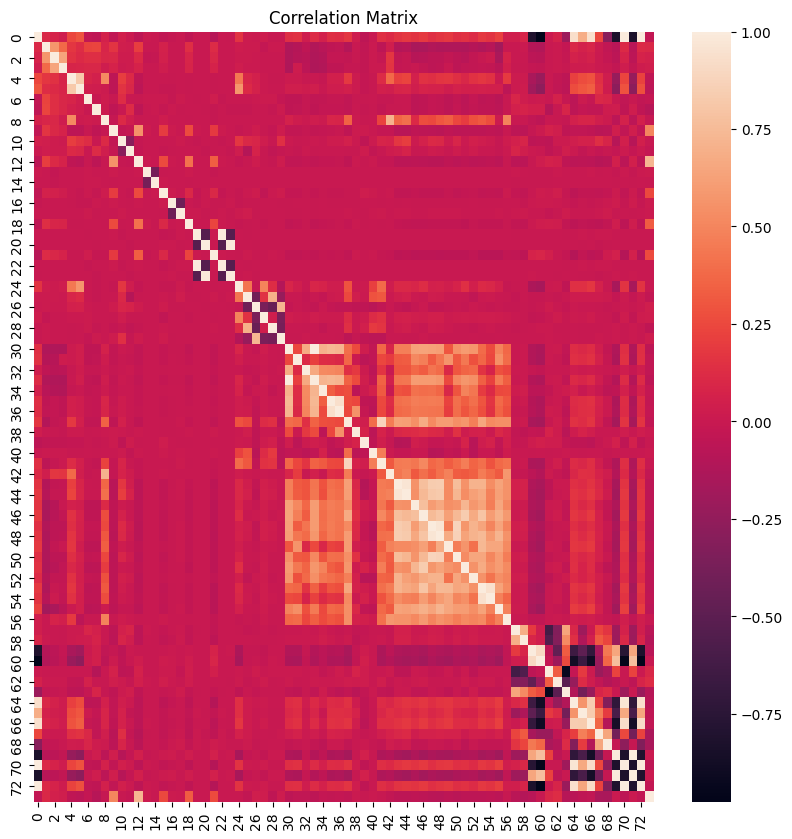

In [ ]:
train_data = np.vstack((X_proc.T,np.log(y/100+1)))
cor_matrix = np.corrcoef(train_data)

# Represent the correlation matrix with heatmap
fig1 = plt.figure(figsize=(10, 10))
fig1 = sns.heatmap(cor_matrix, annot=False)
fig1.set_title('Correlation Matrix')
plt.show()

In [ ]:
# Set the correlation for the target variable
target_correlation = cor_matrix[:73,73]

# Sort the array in descending order and get the sorted indices
sorted_indices = np.argsort(target_correlation)[::-1]

# Print the most important features
print(f'The most correlated features (in order) are: \n\n {features[sorted_indices]}')

The most correlated features (in order) are: 

 Index(['per', 'eps', 'wcr', 'qr', 'der', 'unemployment_rate_proc', 'Ticker',
       'dif_unemployment_rate_proc', 'Industry', 'fcfps_diff2', 'Sector',
       'pcfr', 'pcfr_diff2', 'der_diff1', 'per_diff1',
       'changeInWorkingCapital', 'changeInCash', 'dif_us_gdp_proc',
       'dif_us_population_proc', 'der_diff2', 'qr_diff1', 'fcfps', 'wcr_diff2',
       'qr_diff2', 'wcr_diff1', 'per_diff2',
       'otherCashflowsFromInvestingActivities',
       '10-Year Treasury Constant Maturity Rate', 'freeCashFlow',
       'commonStockSharesOutstanding', 'eps_diff1', 'market_cap',
       'price_diff1', 'endPeriodCashFlow', 'eps_dif2', 'otherCurrentLiab',
       'fcfps_diff1', 'beginPeriodCashFlow', 'researchDevelopment', 'year',
       'us_population_proc', 'totalCashFromOperatingActivities',
       'money_supply_proc', 'intangibleAssets', 'otherCurrentAssets',
       'dif_money_supply_proc', 'pcfr_diff1', 'price',
       'sellingGeneralAdministra

## 3.1 Filtering the data set

1. Delete all instances where target>10.000 and set the maximum target=1.000. Delete target when target < 0.001.

2. Delete instances that contain more than 40% of NAN.

3. Delete companies that have less than three years in the dataset.

4. Delete columns where more than 40 % of the features are NANs.

5. Replace +-inf with np.nan

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/TFM/03. Dataset exports/total_dataset_22_05.csv',sep=';')
#df1 = df1[df1['Ticker'].isin(sp500_list)]

# Drop the index column
df1.drop('Unnamed: 0', axis=1, inplace=True)
print(df1.shape)
## 0. Deleting rows with np.nan in 'Col1'
df1 = df1.dropna(subset=['target'])
print(df1.shape)

## 1. Delete large instances
# Deleting rows where 'Feature' is greater than 10000
df2 = df1[df1['target'] <= 10000]

# Modifying values in 'Feature' column between 1000 and 10000
df2.loc[(df2['target'] >= 1000) & (df2['target'] <= 10000), 'target'] = 1000
print(df2.shape)

## 2. Delete instances where more than 40% are NAN
# Set the threshold
threshold_column = int(len(df2.columns)*0.60)

df3 = df2.dropna(thresh=threshold_column)
print(df3.shape)

## 3. Delete companies that has less than three years in the dataset
# Counting occurrences of each category
counts = df3['Ticker'].value_counts()

# Filtering rows based on category counts
df4 = df3[df3['Ticker'].map(counts) > 3]
print(df4.shape)

## 4. Delete instances where more than 40 % of the features are NANs.
# Set the threshold
threshold_row = int(len(df2)*0.60)

# Deleting columns with more than 40% NaN values
df5 = df4.dropna(axis=1, thresh=threshold_row)
print(df5.shape)

## 5. Replace infinity values with NaN
df5.replace([np.inf, -np.inf], np.nan, inplace=True)

<ipython-input-5-65a465072aa9>:1: DtypeWarning: Columns (10,13,16,19,22) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/drive/MyDrive/TFM/03. Dataset exports/total_dataset_22_05.csv',sep=';')


(65585, 74)
(59570, 74)
(59560, 74)
(59237, 74)
(56475, 74)
(56475, 70)


<ipython-input-5-65a465072aa9>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5.replace([np.inf, -np.inf], np.nan, inplace=True)


In [ ]:
features = df5.columns
features

Index(['year', 'Ticker', 'Industry', 'Sector', 'price', 'price_adjusted',
       'price_diff1', 'price_diff1.1', 'market_cap', 'eps', 'eps_diff1',
       'eps_dif2', 'per', 'per_diff1', 'per_diff2', 'der', 'der_diff1',
       'der_diff2', 'wcr', 'wcr_diff1', 'wcr_diff2', 'qr', 'qr_diff1',
       'qr_diff2', 'fcfps', 'fcfps_diff1', 'fcfps_diff2', 'pcfr', 'pcfr_diff1',
       'pcfr_diff2', 'totalAssets', 'intangibleAssets', 'otherCurrentAssets',
       'totalLiab', 'otherCurrentLiab', 'beginPeriodCashFlow',
       'endPeriodCashFlow', 'totalCashFromOperatingActivities', 'changeInCash',
       'changeInWorkingCapital', 'freeCashFlow', 'incomeBeforeTax',
       'netIncome_x', 'sellingGeneralAdministrative', 'grossProfit', 'ebit',
       'ebitda', 'depreciationAndAmortization', 'operatingIncome',
       'totalOperatingExpenses', 'totalRevenue', 'costOfRevenue',
       'dividendsPaid', 'commonStockSharesOutstanding',
       'Dif 3-Month Treasury Bill: Secondary Market Rate',
       'Dif 10-Y

In [ ]:
df5.describe(include='all')

,year,Ticker,Industry,Sector,price,price_adjusted,price_diff1,price_diff1.1,market_cap,eps,eps_diff1,eps_dif2,per,per_diff1,per_diff2,der,der_diff1,der_diff2,wcr,wcr_diff1,wcr_diff2,qr,qr_diff1,qr_diff2,fcfps,fcfps_diff1,fcfps_diff2,pcfr,pcfr_diff1,pcfr_diff2,totalAssets,intangibleAssets,otherCurrentAssets,totalLiab,otherCurrentLiab,beginPeriodCashFlow,endPeriodCashFlow,totalCashFromOperatingActivities,changeInCash,changeInWorkingCapital,freeCashFlow,incomeBeforeTax,netIncome_x,sellingGeneralAdministrative,grossProfit,ebit,ebitda,depreciationAndAmortization,operatingIncome,totalOperatingExpenses,totalRevenue,costOfRevenue,dividendsPaid,commonStockSharesOutstanding,Dif 3-Month Treasury Bill: Secondary Market Rate,Dif 10-Year Treasury Constant Maturity Rate,3-Month Treasury Bill: Secondary Market Rate,10-Year Treasury Constant Maturity Rate,dif_unemployment_rate_proc,unemployment_rate_proc,dif_employment_proc,employment_proc,dif_money_supply_proc,money_supply_proc,dif_inflation_rate_proc,inflation_rate_proc,dif_us_gdp_proc,us_gdp_proc,dif_us_population_proc,us_population_proc,target
count,9817.000000,9817,9817,9817,9817.000000,9817.000000,9470.000000,9095.000000,9817.000000,9813.00,9464.000000,9088.000000,9813.00,9464.000000,9088.000000,9099,8716.000000,8340.000000,8778,8387.000000,8011.000000,7331,6924.000000,6657.000000,9804.000000,9450.000000,9073.000000,9804.000000,9450.000000,9073.000000,9.175000e+03,7.553000e+03,8.544000e+03,9.173000e+03,8.877000e+03,9.781000e+03,9.790000e+03,9.811000e+03,9.688000e+03,9.799000e+03,9.806000e+03,9.598000e+03,9.815000e+03,8.364000e+03,9.382000e+03,9.752000e+03,9.812000e+03,9.318000e+03,9.492000e+03,9.275000e+03,9.812000e+03,9.162000e+03,8.339000e+03,9.815000e+03,9817.000000,9817.000000,9817.000000,9817.000000,9817.000000,9817.000000,9817.000000,9817.000000,9817.000000,9817.000000,9817.000000,9817.000000,9.817000e+03,9817.000000,9.817000e+03,9.817000e+03,9817.000000
unique,NaN,377,56,11,NaN,NaN,NaN,NaN,NaN,3228.00,NaN,NaN,6678.00,NaN,NaN,1398,NaN,NaN,1557,NaN,NaN,1248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,PSA,Equity Real Estate Investment Trusts (REITs),Financial Services,NaN,NaN,NaN,NaN,NaN,1.81,NaN,NaN,18.22,NaN,NaN,0.24,NaN,NaN,1.03,NaN,NaN,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,36,717,1654,NaN,NaN,NaN,NaN,NaN,21.00,NaN,NaN,8.00,NaN,NaN,100,NaN,NaN,55,NaN,NaN,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2007.199959,NaN,NaN,NaN,73.466107,50.575762,19.825979,19.404854,80.676751,NaN,0.161195,0.009276,NaN,-25.932557,-27.403862,NaN,-0.061720,-0.027469,NaN,3.489839,1.592314,NaN,2.938821,1.266728,2.471017,0.326881,0.253295,0.020336,0.009797,0.009616,5.703295e+10,3.141049e+09,1.057543e+10,4.675312e+10,1.627120e+10,2.421202e+09,2.662609e+09,2.446896e+09,2.618218e+08,-8.202390e+07,1.359267e+09,1.899065e+09,1.348945e+09,2.683041e+09,6.845052e+09,2.440424e+09,3.286236e+09,8.970910e+08,2.425270e+09,4.872098e+09,1.469429e+10,9.412774e+09,6.705373e+08,6.339768e+08,-0.176550,-0.210160,2.300024,3.999036,0.002952,5.888457,1143.314153,132878.817729,593.093511,8633.167243,0.000860,1.024218,2.573732e+06,14912.923022,2.573732e+06,2.994400e+08,18.835184
std,8.997682,NaN,NaN,NaN,155.366577,134.091113,49.611554,50.235444,995.358644,NaN,6.656583,6.483156,NaN,4716.855993,4812.883792,NaN,9.836071,9.891677,NaN,968.679918,985.018291,NaN,1034.716803,1049.330713,10.870190,9.468874,9.470588,0.945895,0.859377,0.876701,2.023713e+11,9.797986e+09,1.056672e+11,1.833879e+11,9.722475e+10,1.325342e+10,1.553869e+10,6.818549e+09,5.630123e+09,6.70

# 4. First rough model

## 4.1 Prediction model


### 4.1.1 Model

Generate a numpy array that contains: **year | data | target**

In [ ]:
dum_errors = []
rf_errors = []
et_errors = []
gb_errors = []
svr_errors = []

n_models = 4
y_dict = {}

for year in range(2000,2022):

    y_store = pd.DataFrame()

    print(f'######  Model for year {year}, in process...  #######')

    # Define the file path
    file_X_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_train_',str(year),'.csv'])
    file_X_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_test_',str(year),'.csv'])
    file_y_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_train_',str(year),'.csv'])
    file_y_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_test_',str(year),'.csv'])

    # Read the CSV file into a NumPy array
    X_train = np.genfromtxt(file_X_train, delimiter=',')
    X_test = np.genfromtxt(file_X_test, delimiter=',')
    y_train = np.genfromtxt(file_y_train, delimiter=',')
    y_test = np.genfromtxt(file_y_test, delimiter=',')

    y_train = np.log(y_train/100+1)
    y_test = np.log(y_test/100+1)

    print(f'Training instances: {X_train.shape[0]}')
    print(f'Testing instances: {X_test.shape[0]}')

    ################
    # Fit different models:
    ################

    # Dummy model
    dum = DummyRegressor()
    dum_model = dum.fit(X_train, y_train)
    y_pred_dum = dum_model.predict(X_test)
    y_pred_train_dum = dum_model.predict(X_train)

    rmse_dum_train = mean_squared_error(y_train, y_pred_train_dum)
    rmse_dum_test = mean_squared_error(y_test, y_pred_dum)
    dum_errors.append(rmse_dum_test)

    # Random forest regressor
    rf = RandomForestRegressor(min_samples_split=0.025, random_state=42)
    rf_model = rf.fit(X_train, y_train)
    y_pred_rf = rf_model.predict(X_test)

    rmse_rf_test = mean_squared_error(y_test, y_pred_rf)
    rf_errors.append(rmse_rf_test)

    # Extremely randomized trees
    et = ExtraTreesRegressor(min_samples_split=0.025, random_state=42)
    et_model = et.fit(X_train, y_train)
    y_pred_train_et = et_model.predict(X_train)
    y_pred_et = et_model.predict(X_test)

    rmse_et_train = mean_squared_error(y_train, y_pred_train_et)
    rmse_et_test = mean_squared_error(y_test, y_pred_et)
    et_errors.append(rmse_et_test)

    # Gradient Boosting regressor
    gb = GradientBoostingRegressor(min_samples_split=0.025, random_state=42)
    gb_model = gb.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)

    rmse_gb_test = mean_squared_error(y_test, y_pred_gb)
    gb_errors.append(rmse_gb_test)

    # Support Vector regressor
    svr = SVR()
    svr_model = svr.fit(X_train, y_train)
    y_pred_svr = svr_model.predict(X_test)

    rmse_svr_test = mean_squared_error(y_test, y_pred_svr)
    svr_errors.append(rmse_svr_test)

    ##############
    # Store the results:
    ##############
    y_store['y_test'] = y_test
    y_store['return'] = (np.exp(y_test)+1)*100
    y_store['y_pred_rf'] = y_pred_rf
    y_store['y_pred_et'] = y_pred_et
    y_store['y_pred_gb'] = y_pred_gb
    y_store['y_pred_svr'] = y_pred_svr

    y_dict[year] = y_store

    ##############
    # Prints:
    ##############
    print(f'MSE for Dummy model TRAINING: {rmse_dum_train}')
    print(f'MSE for Dummy model: {rmse_dum_test}')
    print(f'MSE for Random Forest: {rmse_rf_test}')
    print(f'MSE for Extremely randomized trees TRAINING : {rmse_et_train}')
    print(f'MSE for Extremely randomized trees: {rmse_et_test}')
    print(f'MSE for Gradient Boosting: {rmse_gb_test}')
    print(f'MSE for SVR: {rmse_svr_test}')
    print(f'######  Model for year {year}, done  #######')

######  Model for year 2000, in process...  #######
Training instances: 2308
Testing instances: 281
MSE for Dummy model TRAINING: 0.11974498404412379
MSE for Dummy model: 0.18732290462799742
MSE for Random Forest: 0.21773000381081456
MSE for Extremely randomized trees TRAINING : 0.004211128671416829
MSE for Extremely randomized trees: 0.21867764784993354
MSE for Gradient Boosting: 0.21514296554182785
MSE for SVR: 0.19903394437612182
######  Model for year 2000, done  #######
######  Model for year 2001, in process...  #######
Training instances: 2589
Testing instances: 292
MSE for Dummy model TRAINING: 0.12686464362150277
MSE for Dummy model: 0.25522533933808156
MSE for Random Forest: 0.26858708176102086
MSE for Extremely randomized trees TRAINING : 0.005346655605728935
MSE for Extremely randomized trees: 0.2799377815101531
MSE for Gradient Boosting: 0.2791963851261763
MSE for SVR: 0.25141018639865675
######  Model for year 2001, done  #######
######  Model for year 2002, in process...

In [ ]:
# Some errors and deviations
dum_errors_serie = pd.Series(dum_errors)
print(f'Dummy error: {dum_errors_serie.mean()}+-{dum_errors_serie.std()}')
rf_errors_serie = pd.Series(rf_errors)
print(f'RF error: {rf_errors_serie.mean()}+-{rf_errors_serie.std()}')
et_errors_serie = pd.Series(et_errors)
print(f'ET error: {et_errors_serie.mean()}+-{et_errors_serie.std()}')
gb_errors_serie = pd.Series(gb_errors)
print(f'GB error: {gb_errors_serie.mean()}+-{gb_errors_serie.std()}')
svr_errors_serie = pd.Series(svr_errors)
print(f'SVR error: {svr_errors_serie.mean()}+-{svr_errors_serie.std()}')

Dummy error: 0.1200726786526871+-0.13409042912777816
RF error: 0.15823824583970858+-0.154208052374584
ET error: 0.14880320730836927+-0.15074054385008256
GB error: 0.14830060347141805+-0.1480590385975353
SVR error: 0.13021632867625016+-0.13441625224375525


### 4.1.2 Evaluatating prediction model

In [ ]:
selection = 25

mean_return = []
rf_return = []
et_return = []
gb_return = []
svr_return = []

for year in range(2000,2022):

    df = y_dict[year]

    df['return'] = (np.exp(df['y_test'])-1)*100
    # Sorting the dataframe by the 'column_name' column in descending order
    sorted_rf = df.loc[:,['return','y_pred_rf']].sort_values('y_pred_rf', ascending=False)
    sorted_et = df.loc[:,['return','y_pred_et']].sort_values('y_pred_et', ascending=False)
    sorted_gb = df.loc[:,['return','y_pred_gb']].sort_values('y_pred_gb', ascending=False)
    sorted_svr = df.loc[:,['return','y_pred_svr']].sort_values('y_pred_svr', ascending=False)

        # Calculate relevant variables
    mean_rf = sorted_rf['return'][:selection].mean()
    mean_et = sorted_et['return'][:selection].mean()
    mean_gb = sorted_gb['return'][:selection].mean()
    mean_svr = sorted_svr['return'][:selection].mean()


    whole_mean = df['return'].mean()

    mean_return.append(whole_mean)
    rf_return.append(mean_rf)
    et_return.append(mean_et)
    gb_return.append(mean_gb)
    svr_return.append(mean_svr)

        # Print relevant variables
    print(f'\n#### Results for year {year}')
    print(f'Mean for whole companies: {whole_mean}')
    print(f'Mean for top companies RF: {mean_rf}')
    print(f'Mean for top companies ET: {mean_et}')
    print(f'Mean for top companies GB: {mean_gb}')
    print(f'Mean for top companies SVR: {mean_svr}')


#### Results for year 2000
Mean for whole companies: 9.754783235270462
Mean for top companies RF: 12.653647507319997
Mean for top companies ET: 7.619012125959997
Mean for top companies GB: 11.04117702116
Mean for top companies SVR: 16.23954556072

#### Results for year 2001
Mean for whole companies: -6.4345803658527405
Mean for top companies RF: 3.2766669468399976
Mean for top companies ET: -4.890565329360003
Mean for top companies GB: -7.32580922208
Mean for top companies SVR: -3.4906707581600016

#### Results for year 2002
Mean for whole companies: 49.559558214879196
Mean for top companies RF: 46.849496727160016
Mean for top companies ET: 30.679167042960003
Mean for top companies GB: 32.87736623304
Mean for top companies SVR: 60.6787159778

#### Results for year 2003
Mean for whole companies: 27.804786859897014
Mean for top companies RF: 27.154872048920005
Mean for top companies ET: 18.80772010356
Mean for top companies GB: 23.70206531496
Mean for top companies SVR: 18.0642502386800

In [ ]:
returns = pd.read_excel('/content/drive/MyDrive/TFM/03. Dataset exports/sp500_returns.xlsx')

In [ ]:
returns.mean()

<ipython-input-8-fbdc5fafdd17>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  returns.mean()


return    8.604091
dtype: float64

In [ ]:
# Append columns to the original series
returns['avg'] = pd.Series(mean_return)
returns['rf'] = pd.Series(rf_return)
returns['et'] = pd.Series(et_return)
returns['gb'] = pd.Series(gb_return)
returns['svr'] = pd.Series(svr_return)


# Dataframe with accumulated results:
ac_return = pd.DataFrame({'year':[2000],
                                          'index_return':[float((1+returns.iloc[0,1]/100))],
                                          'avg_return':[float((1+returns.iloc[0,2]/100))],
                                          'rf_return':[float((1+returns.iloc[0,3]/100))],
                                          'et_return':[float((1+returns.iloc[0,4]/100))],
                                          'gb_return':[float((1+returns.iloc[0,5]/100))],
                                          'svr_return':[float((1+returns.iloc[0,6]/100))]})

In [ ]:
for year in range(2001,2022):
    print(year)
    new_row = {
            'year':[year],
            'index_return': [float(ac_return.loc[ac_return['year']==year-1,'index_return'])*float((1+returns.iloc[year-2000,1]/100))],
            'avg_return': [float(ac_return.loc[ac_return['year']==year-1,'avg_return'])*float((1+returns.iloc[year-2000,2]/100))],
            'rf_return': [float(ac_return.loc[ac_return['year']==year-1,'rf_return'])*float((1+returns.iloc[year-2000,3]/100))],
            'et_return': [float(ac_return.loc[ac_return['year']==year-1,'et_return'])*float((1+returns.iloc[year-2000,4]/100))],
            'gb_return': [float(ac_return.loc[ac_return['year']==year-1,'gb_return'])*float((1+returns.iloc[year-2000,5]/100))],
            'svr_return': [float(ac_return.loc[ac_return['year']==year-1,'svr_return'])*float((1+returns.iloc[year-2000,6]/100))]
        }

    # Append the new columns to the original dataframe
    ac_return = pd.concat([ac_return, pd.DataFrame(new_row)], axis=0)

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


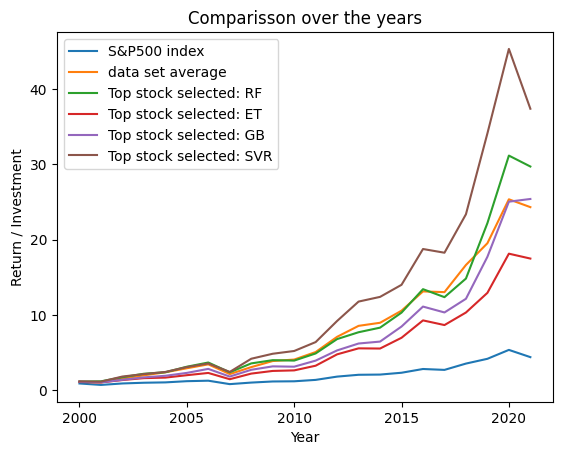

In [ ]:
# Create the plot
plt.plot(ac_return['year'], ac_return['index_return'], label='S&P500 index')
plt.plot(ac_return['year'], ac_return['avg_return'], label='data set average')
plt.plot(ac_return['year'], ac_return['rf_return'], label='Top stock selected: RF')
plt.plot(ac_return['year'], ac_return['et_return'], label='Top stock selected: ET')
plt.plot(ac_return['year'], ac_return['gb_return'], label='Top stock selected: GB')
plt.plot(ac_return['year'], ac_return['svr_return'], label='Top stock selected: SVR')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Return / Investment')
plt.title('Comparisson over the years')

# Add legend
plt.legend()

# Show the plot
plt.show()

Generate a t-test to check if the SVR is certainly beating the average market.

In [ ]:
serie_ttest = returns['svr']-returns['avg']

# Perform t-test
t_statistic, p_value = ttest_1samp(serie_ttest, 0, alternative='greater')

print("T-statistic:", t_statistic)
print("P-value:", p_value)

T-statistic: 1.2869672557587795
P-value: 0.10605570560148031


### 4.1.3 Classification model with sliding window


## 4.2 Classification model


### 4.2.1 Model


In [5]:
y_dict = {}
acc_dum_lst = []
acc_et_lst = []
acc_knn_lst = []
acc_svc_lst = []

for year in range(2000,2022):

    print(f'######  Model for year {year}, in process...  #######')

    # Define the file path
    file_X_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_train_',str(year),'.csv'])
    file_X_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/X_test_',str(year),'.csv'])
    file_y_train = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_train_',str(year),'.csv'])
    file_y_test = ''.join(['/content/drive/MyDrive/TFM/05. Preprocessed data/sp500/y_test_',str(year),'.csv'])

    # Read the CSV file into a NumPy array
    X_train = np.genfromtxt(file_X_train, delimiter=',')
    X_test = np.genfromtxt(file_X_test, delimiter=',')
    y_train = np.genfromtxt(file_y_train, delimiter=',')
    y_test = np.genfromtxt(file_y_test, delimiter=',')

    print(f'Training instances: {X_train.shape[0]}')
    print(f'Testing instances: {X_test.shape[0]}')

    # Set the target variable:
    y_classification_train = np.zeros(len(y_train))
    y_classification_train[y_train > 0] = 1

    y_classification_test = np.zeros(len(y_test))
    y_classification_test[y_test > 0] = 1

    ################
    # Fit the model:
    ################

    # Dummy classifier
    dummy = DummyClassifier(strategy='most_frequent').fit(X_train,y_classification_train)

    # Random forest classifier
    et = ExtraTreesClassifier(min_samples_split=0.025, random_state=42)
    model_et = et.fit(X_train, y_classification_train)

    # K Nearest Neighours
    knn = KNeighborsClassifier(n_neighbors=30)
    model_knn = knn.fit(X_train, y_classification_train)

    # Support Vector Classifier
    svc = SVC(probability=True, random_state=42)
    model_svc = svc.fit(X_train, y_classification_train)

    ###############
    # Predictions:
    ###############
    # Predict on the train data
    y_pred_dum_train = dummy.predict(X_train)
    y_pred_et_train = model_et.predict(X_train)
    y_pred_knn_train = model_knn.predict(X_train)
    y_pred_svc_train = model_svc.predict(X_train)

    # Predict on the test data
    y_pred_dum_test = dummy.predict(X_test)
    y_pred_et_test = model_et.predict(X_test)
    y_pred_knn_test = model_knn.predict(X_test)
    y_pred_svc_test = model_svc.predict(X_test)

    # Calculate the probabilities
    y_prob_et = model_et.predict_proba(X_test)
    y_prob_knn = model_knn.predict_proba(X_test)
    y_prob_svc = model_svc.predict_proba(X_test)

    ###############
    # Metrics:
    ###############

    print(f'######  Model for year {year}, done  #######')

    # Calculate the accuracy on the train data
    acc_dum_train = accuracy_score(y_classification_train, y_pred_dum_train)
    acc_et_train = accuracy_score(y_classification_train, y_pred_et_train)
    acc_knn_train = accuracy_score(y_classification_train, y_pred_knn_train)
    acc_svc_train = accuracy_score(y_classification_train, y_pred_svc_train)
    # Calculate the accuracy on the test data
    acc_dum_test = accuracy_score(y_classification_test, y_pred_dum_test)
    acc_et_test = accuracy_score(y_classification_test, y_pred_et_test)
    acc_knn_test = accuracy_score(y_classification_test, y_pred_knn_test)
    acc_svc_test = accuracy_score(y_classification_test, y_pred_svc_test)

    acc_dum_lst.append(acc_dum_test)
    acc_et_lst.append(acc_et_test)
    acc_knn_lst.append(acc_knn_test)
    acc_svc_lst.append(acc_svc_test)

    print(f'Train accuracy for dummy model: {acc_dum_train}')
    print(f'Train accuracy for Extratrees classifier: {acc_et_train}')
    print(f'Train accuracy for KNN: {acc_knn_train}')
    print(f'Train accuracy for Support vector classifier: {acc_svc_train}\n')
    print(f'Test accuracy for dummy model: {acc_dum_test}')
    print(f'Test accuracy for Extratrees classifier: {acc_et_test}')
    print(f'Test accuracy for KNN: {acc_knn_test}')
    print(f'Test accuracy for Support vector classifier: {acc_svc_test}\n')

    ##############
    # Store the results:
    ##############
    y_store = pd.DataFrame(columns=['y_test','y_prob_et','y_prob_knn','y_prob_svc'])

    y_store['y_test'] = y_test
    y_store['y_prob_et'] = y_prob_et[:,1]
    y_store['y_prob_knn'] = y_prob_knn[:,1]
    y_store['y_prob_svc'] = y_prob_svc[:,1]

    y_dict[year] = y_store

######  Model for year 2000, in process...  #######
Training instances: 2308
Testing instances: 281
######  Model for year 2000, done  #######
Train accuracy for dummy model: 0.7110051993067591
Train accuracy for Extratrees classifier: 0.9129116117850953
Train accuracy for KNN: 0.811525129982669
Train accuracy for Support vector classifier: 0.9380415944540728

Test accuracy for dummy model: 0.5765124555160143
Test accuracy for Extratrees classifier: 0.5800711743772242
Test accuracy for KNN: 0.5765124555160143
Test accuracy for Support vector classifier: 0.5658362989323843

######  Model for year 2001, in process...  #######
Training instances: 2589
Testing instances: 292
######  Model for year 2001, done  #######
Train accuracy for dummy model: 0.6964078794901506
Train accuracy for Extratrees classifier: 0.9150251062186172
Train accuracy for KNN: 0.8049439938200077
Train accuracy for Support vector classifier: 0.9382000772499034

Test accuracy for dummy model: 0.4315068493150685
Test a

In [6]:
# Some accuracies and deviations
dum_acc_serie = pd.Series(acc_dum_lst)
print(f'Dummy accuracy: {dum_acc_serie.mean()}+-{dum_acc_serie.std()}')
et_acc_serie = pd.Series(acc_et_lst)
print(f'ET accuracy: {et_acc_serie.mean()}+-{et_acc_serie.std()}')
knn_acc_serie = pd.Series(acc_knn_lst)
print(f'KNN accuracy: {knn_acc_serie.mean()}+-{knn_acc_serie.std()}')
svc_acc_serie = pd.Series(acc_svc_lst)
print(f'SVC accuracy: {svc_acc_serie.mean()}+-{svc_acc_serie.std()}')

Dummy accuracy: 0.7086814203597854+-0.22919132347836524
ET accuracy: 0.6882189238442744+-0.2162560212594992
KNN accuracy: 0.6835090775710367+-0.21338267060691407
SVC accuracy: 0.6732885198586959+-0.20108640942813424


In [ ]:
for year in range(2000,2022):

    # Dataframe
    df = y_dict[year]
    # File name
    file_results = ''.join(['/content/drive/MyDrive/TFM/06. Results/sp500/results_',str(year),'.csv'])

    df.to_csv(file_results, sep=',')


### 4.2.2 ROC curve on classification model

In [ ]:
for year in range(2000,2022):
    y_store = y_dict[year]

    y_test = y_store['y_test']
    y_test_clf = np.zeros(len(y_test))
    y_test_clf[y_test > 0] = 1
    y_prob = y_store['y_prob_et']
    y_test_pred = np.zeros(len(y_prob))
    y_test_pred[y_prob > 0.50] = 1

    f1_test = f1_score(y_test_clf, y_test_pred)
    print(f"\nTest f1_score for the year {year}: {f1_test} \n")

    # Computation of the accuracy and confusion matrix
    conf_matrix = confusion_matrix(y_test_clf, y_test_pred)

    # Heatmap
    fig1 = sns.heatmap(conf_matrix, annot=True, cmap='Reds')
    fig1.set_ylabel('True class')
    fig1.set_xlabel('Pred class')
    plt.show()

    # Calculate AUC score
    auc_score = roc_auc_score(y_test_clf, y_prob)
    print(f'AUC for year {year}: {round(auc_score,3)}\n')

    # Calculate fpr and tpr
    fpr, tpr, thresholds = roc_curve(y_test_clf, y_prob)

    # Plot ROC curve
    plt.plot(fpr, tpr, color='red', label='ROC curve')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.title('ROC curve')

    # Obtain the index of the best threshold
    opt_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[opt_index]
    plt.scatter(fpr[opt_index], tpr[opt_index], s=50, marker='o', color='blue')

    plt.show()

    print('\nThe optimal threshold is', round(optimal_threshold,3))

### 4.2.3 Evaluation of the percentiles of the classificated data
Conffussion matrices are not giving good results:

In [ ]:
for year in range(2000,2022):

    y_store = y_dict[year]

    y_test = y_store['y_test']
    y_prob_clf_test = y_store['y_prob_et']


    sorted_indices_test = y_prob_clf_test.argsort()

    test_len = len(y_test)

    y_test_df = pd.DataFrame(y_test)

    avg_target_test = []
    median_target_test = []

    for i in range(10):

        avg_test = y_test_df.iloc[sorted_indices_test[i*round(test_len/10):(i+1)*round(test_len/10)]].mean()
        med_test = y_test_df.iloc[sorted_indices_test[i*round(test_len/10):(i+1)*round(test_len/10)]].median()

        avg_target_test.append(avg_test)
        median_target_test.append(med_test)

    print(f'########### Results for year {year} #############')
    print(avg_target_test)
    print(median_target_test)

### 4.2.4 Evaluation of the best

In [7]:
selection = 25

mean_return = []
et_return = []
knn_return = []
svc_return = []

for year in range(2000,2022):

    # File name
    file_name = ''.join(['/content/drive/MyDrive/TFM/06. Results/sp500/results_',str(year),'.csv'])

    df = pd.read_csv(file_name)

    sorted_et = df.loc[:,['y_test','y_prob_et']].sort_values('y_prob_et', ascending=False)
    sorted_knn = df.loc[:,['y_test','y_prob_knn']].sort_values('y_prob_knn', ascending=False)
    sorted_svc = df.loc[:,['y_test','y_prob_svc']].sort_values('y_prob_svc', ascending=False)

        # Calculate relevant variables
    mean_et = sorted_et['y_test'][:selection].mean()
    median_et = sorted_et['y_test'][:selection].median()
    mean_knn = sorted_knn['y_test'][:selection].mean()
    median_knn = sorted_knn['y_test'][:selection].median()
    mean_svc = sorted_svc['y_test'][:selection].mean()
    median_svc = sorted_svc['y_test'][:selection].median()

    whole_mean = df['y_test'].mean()
    whole_median = df['y_test'].median()

    mean_return.append(whole_mean)
    et_return.append(mean_et)
    knn_return.append(mean_knn)
    svc_return.append(mean_svc)

        # Print relevant variables
    print(f'\n#### Results for year {year}')
    print(f'Mean for whole companies: {whole_mean}')
    print(f'Median for whole companies: {whole_median}')

    print(f'Mean for top companies ET: {mean_et}')
    print(f'Median for top companies ET: {median_et}')
    print(f'Mean for top companies KNN: {mean_knn}')
    print(f'Median for top companies KNN: {median_knn}')
    print(f'Mean for top companies SVC: {mean_svc}')
    print(f'Median for top companies SVC: {median_svc} \n')


#### Results for year 2000
Mean for whole companies: 9.75478323527046
Median for whole companies: 5.70698425
Mean for top companies ET: 12.922422749000003
Median for top companies ET: 11.79315765
Mean for top companies KNN: 18.722235649599998
Median for top companies KNN: 16.2592315
Mean for top companies SVC: 23.18993915648
Median for top companies SVC: 19.02065175 


#### Results for year 2001
Mean for whole companies: -6.434580365852739
Median for whole companies: -4.19322078
Mean for top companies ET: 0.2104817031599999
Median for top companies ET: 4.244442098
Mean for top companies KNN: -9.44565311964
Median for top companies KNN: 0.869478664
Mean for top companies SVC: 4.032753887080002
Median for top companies SVC: 5.071930649 


#### Results for year 2002
Mean for whole companies: 49.559558214879196
Median for whole companies: 29.26954489
Mean for top companies ET: 34.56834141632
Median for top companies ET: 29.18471344
Mean for top companies KNN: 37.75856674512
Median for top

### 4.2.5 Comparisson over the years

In [8]:
returns = pd.read_excel('/content/drive/MyDrive/TFM/03. Dataset exports/sp500_returns.xlsx')

In [9]:
# Append columns to the original series
returns['avg'] = pd.Series(mean_return)
returns['et'] = pd.Series(et_return)
returns['knn'] = pd.Series(knn_return)
returns['svc'] = pd.Series(svc_return)

# Dataframe with accumulated results:
ac_return = pd.DataFrame({'year':[2000],
                                          'index_return':[float((1+returns.iloc[0,1]/100))],
                                          'avg_return':[float((1+returns.iloc[0,2]/100))],
                                          'et_return':[float((1+returns.iloc[0,3]/100))],
                                          'knn_return':[float((1+returns.iloc[0,4]/100))],
                                          'svc_return':[float((1+returns.iloc[0,5]/100))]})

In [10]:
for year in range(2001,2022):

    new_row = {
            'year':[year],
            'index_return': [float(ac_return.loc[ac_return['year']==year-1,'index_return'])*float((1+returns.iloc[year-2000,1]/100))],
            'avg_return': [float(ac_return.loc[ac_return['year']==year-1,'avg_return'])*float((1+returns.iloc[year-2000,2]/100))],
            'et_return': [float(ac_return.loc[ac_return['year']==year-1,'et_return'])*float((1+returns.iloc[year-2000,3]/100))],
            'knn_return': [float(ac_return.loc[ac_return['year']==year-1,'knn_return'])*float((1+returns.iloc[year-2000,4]/100))],
            'svc_return': [float(ac_return.loc[ac_return['year']==year-1,'svc_return'])*float((1+returns.iloc[year-2000,5]/100))]
        }

    # Append the new columns to the original dataframe
    ac_return = pd.concat([ac_return, pd.DataFrame(new_row)], axis=0)

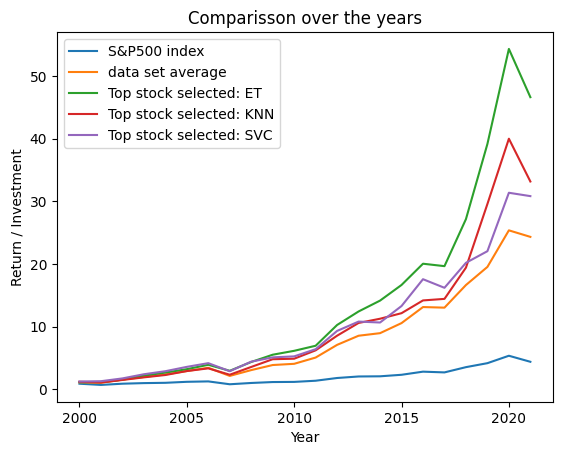

In [11]:
# Create the plot
plt.plot(ac_return['year'], ac_return['index_return'], label='S&P500 index')
plt.plot(ac_return['year'], ac_return['avg_return'], label='data set average')
plt.plot(ac_return['year'], ac_return['et_return'], label='Top stock selected: ET')
plt.plot(ac_return['year'], ac_return['knn_return'], label='Top stock selected: KNN')
plt.plot(ac_return['year'], ac_return['svc_return'], label='Top stock selected: SVC')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Return / Investment')
plt.title('Comparisson over the years')

# Add legend
plt.legend()

# Show the plot
plt.show()

### 4.2.6 Statistical test to the results

In [ ]:
# Create a pandas Series with random values
diff_et = returns.et - returns.avg
diff_knn = returns.knn - returns['return']
diff_svc = returns.svc - returns['return']

# Perform one-sample t-test
t_statistic, p_value = ttest_1samp(diff_et, 0, alternative='greater')

# Print the results
print("One-Sample t-test Results:")
print(f"t-statistic: {t_statistic}")
print(f"p-value: {p_value}")

One-Sample t-test Results:
t-statistic: 1.696575055871583
p-value: 0.0522758028381129


In [13]:
returns.mean()

<ipython-input-13-fbdc5fafdd17>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  returns.mean()


return     8.604091
avg       17.340686
et        20.692726
knn       19.257713
svc       18.538956
dtype: float64